In [6]:
from scipy import sparse
from bluepysnap import Circuit
from graph_analysis.randomize import DistanceDependentConfigurationalModel
# from graph_analysis.randomize import WeightedShuffledModel
import graph_analysis as ga
from graph_analysis.rich_cub import RichClubAnalysis
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
file_format = 'png'
dpi = 300

In [4]:
adj_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca1_synaptome.npz'
synaptome = sparse.load_npz(adj_path)
connectome = synaptome.copy()
connectome[connectome > 0] = 1
# del synaptome

target = 'slice10'
CIRCUIT_DIR =  '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/sonata/circuit_config.json'
circuit = Circuit(CIRCUIT_DIR)
nodes = circuit.nodes["hippocampus_neurons"]
edges = circuit.edges["hippocampus_neurons__hippocampus_neurons__chemical_synapse"]
target_indices = nodes.ids(target)
target_synaptome = synaptome[target_indices,:][:,target_indices]
target_connectome = connectome[target_indices,:][:,target_indices]

In [8]:
# model_dp = WeightedShuffledModel(target_synaptome)
model_dp = ga.randomize.WeightPermutedRandomModel(target_synaptome)

dp_adj = model_dp.generate()

In [4]:
rca_syn = RichClubAnalysis(target_synaptome)
rca_dp = RichClubAnalysis(dp_adj)

<__array_function__ internals>:200: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.


In [11]:
rca_syn.total_degree.max()

31232.0

In [13]:
rca_syn.is_MultiGraph

True

In [12]:
rca_dp.total_degree.max()

30702.0

In [7]:
# max_workers = 8
# cluster = LocalCluster(n_workers=max_workers)

client = Client()    # Start Dask client
k_dict_parallel_model = rca_syn.calculate_rich_club_coefficients(weighted=True,
                            method='strongest-links-in-network',step=100)
k_dict_parallel_dp = rca_dp.calculate_rich_club_coefficients(weighted=True,
                            method='strongest-links-in-network',step=100)
client.shutdown()    # Shutdown the Dask client

2023-07-07 21:29:49,683 - distributed.diskutils - INFO - Found stale lock file and directory '/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/kurban/1611154/dask-worker-space/worker-3tmr1qpj', purging
2023-07-07 21:29:49,683 - distributed.diskutils - INFO - Found stale lock file and directory '/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/kurban/1611154/dask-worker-space/worker-dh7ts2ge', purging


In [27]:
# since keeping weighted degrees are not available yet, lets cap the first N weighted degrees from the minimum shape we have
model_rc_coeffs = pd.DataFrame.from_dict(k_dict_parallel_model.values())
random_rc_coeffs = pd.DataFrame.from_dict(k_dict_parallel_dp.values())

capped_value = min(model_rc_coeffs.values.flatten().shape[0],random_rc_coeffs.values.flatten().shape[0])

In [28]:
capped_value

308

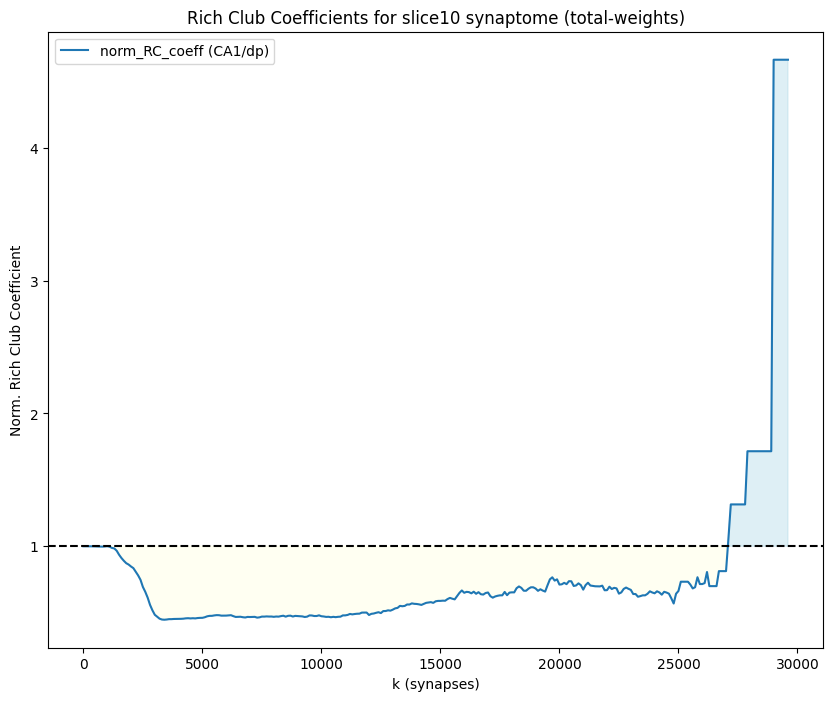

In [58]:
f ,ax= plt.subplots(figsize=(10,8))

orig_values = np.array(list(k_dict_parallel_model.values()))
random_values = np.array(list(k_dict_parallel_dp.values()))
norm_rc = orig_values[:random_values.shape[0]] / random_values
plt.plot(k_dict_parallel_dp.keys(),norm_rc)

ax.fill_between(k_dict_parallel_dp.keys(), norm_rc, 1, where=(np.array(norm_rc) >= 1), color='lightblue',alpha=0.4)
ax.fill_between(k_dict_parallel_dp.keys(), norm_rc, 1, where=(np.array(norm_rc) < 1), color='lightyellow',alpha=0.4)

ax.axhline(y=1, color='k', linestyle='--', label='y=1')


plt.title('Rich Club Coefficients for slice10 synaptome (total-weights)')
plt.xlabel('k (synapses)')
plt.ylabel('Norm. Rich Club Coefficient')
plt.legend(['norm_RC_coeff (CA1/dp)'])
plt.savefig(f"../output/rich_club_directed_totdegree_weighted.png", dpi=dpi, bbox_inches='tight')

In [63]:
np.testing.assert_equal(dp_adj.sum(),target_synaptome.sum())

In [65]:
np.testing.assert_array_almost_equal(rca_syn.total_degree,rca_dp.total_degree)

AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 12594 / 12615 (99.8%)
Max absolute difference: 3953.
Max relative difference: 0.96825397
 x: array([2330.,  127., 1811., ..., 7371., 6278., 8740.])
 y: array([2315.,  123., 1843., ..., 7371., 5359., 7846.])

In [66]:
dp_connectome = dp_adj.copy()
dp_connectome[dp_connectome>1] = 1

In [70]:
np.testing.assert_equal(target_connectome.max(),dp_connectome.max())

In [71]:
dp_connectome_indegrees = dp_connectome.sum(axis=0).A.flatten()
dp_connectome_outdegrees = dp_connectome.sum(axis=1).A.flatten()
dp_connectome_totaldegrees = dp_connectome_indegrees + dp_connectome_outdegrees

model_connectome_indegrees = target_connectome.sum(axis=0).A.flatten()
model_connectome_outdegrees = target_connectome.sum(axis=1).A.flatten()
model_connectome_totaldegrees = model_connectome_indegrees + model_connectome_outdegrees

In [77]:
np.testing.assert_array_almost_equal(dp_connectome_indegrees.sum(),model_connectome_indegrees.sum())

AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 1 / 1 (100%)
Max absolute difference: 74675.
Max relative difference: 0.02686544
 x: array(2704918.)
 y: array(2779593.)

In [78]:
np.testing.assert_array_almost_equal(dp_connectome_outdegrees.sum(),model_connectome_outdegrees.sum())

AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 1 / 1 (100%)
Max absolute difference: 74675.
Max relative difference: 0.02686544
 x: array(2704918.)
 y: array(2779593.)

In [79]:
np.testing.assert_array_almost_equal(dp_connectome_totaldegrees.sum(),model_connectome_totaldegrees.sum())

AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 1 / 1 (100%)
Max absolute difference: 149350.
Max relative difference: 0.02686544
 x: array(5409836.)
 y: array(5559186.)

In [82]:
np.testing.assert_array_almost_equal(target_connectome.A,dp_connectome.A)

AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 5203411 / 159138225 (3.27%)
Max absolute difference: 1.
Max relative difference: 1.
 x: array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],...
 y: array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],...

In [125]:
model_dp2 = WeightedShuffledModel(target_connectome).generate()

In [126]:
np.testing.assert_array_almost_equal(target_connectome.A,model_dp2.A)

AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 5212680 / 159138225 (3.28%)
Max absolute difference: 6.
Max relative difference: 1.
 x: array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],...
 y: array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],...

In [137]:
np.testing.assert_array_equal(target_connectome.sum(axis=1).A.flatten() , model_dp2.sum(axis=1).A.flatten()) # outdegrees SUCCESS if connectome is given as randomization input, if synaptome input, then no

In [128]:
np.testing.assert_array_equal(target_connectome.sum(axis=0).A.flatten() , model_dp2.sum(axis=0).A.flatten()) # indegrees SUCCESS if connectome is given as randomization input, if synaptome input, then no

In [138]:
np.testing.assert_array_equal(target_connectome.count_nonzero() , model_dp2.count_nonzero()) # although degrees match, nonzero counts dont

AssertionError: 
Arrays are not equal

Mismatched elements: 1 / 1 (100%)
Max absolute difference: 74543
Max relative difference: 0.02755698
 x: array(2779593)
 y: array(2705050)

In [144]:
target_connectome.data.shape[0] -  model_dp2.data.shape[0]

74543

In [129]:
model_dp2coo = model_dp2.copy().tocoo()
model_dp2coo.data = target_synaptome.data
model_dp2coo.data = np.random.permutation(model_dp2coo.data)

In [118]:
np.testing.assert_array_equal(target_connectome.sum(axis=0).A.flatten() , model_dp2coo.sum(axis=0).A.flatten()) # now that we changed weights, summing wont work but count nonzero does

AssertionError: 
Arrays are not equal

Mismatched elements: 12613 / 12615 (100%)
Max absolute difference: 5999.
Max relative difference: 0.90425532
 x: array([  7.,   2.,   8., ..., 198., 420., 485.])
 y: array([  17.,    4.,   23., ..., 1169., 2011., 2572.])

In [130]:
target_connectome.count_nonzero()

2779593

In [131]:
model_dp2coo.count_nonzero()

2705050

In [122]:
np.testing.assert_equal(target_connectome.count_nonzero() , model_dp2coo.count_nonzero()) # now that we changed weights, summing wont work but count nonzero does

AssertionError: 
Items are not equal:
 ACTUAL: 2779593
 DESIRED: 2705321

In [132]:
model_dp2.count_nonzero() == model_dp2coo.count_nonzero()

True

In [136]:
model_dp2.count_nonzero()

2705050

In [115]:
target_connectome.count_nonzero() == model_dp2coo.count_nonzero()

False

In [116]:
target_synaptome.count_nonzero() == model_dp2coo.count_nonzero()

False

In [145]:
synaptome_weight_permuted = target_synaptome.copy().tocoo()
synaptome_weight_permuted.data = np.random.permutation(synaptome_weight_permuted.data)

In [149]:
np.testing.assert_equal(synaptome_weight_permuted.count_nonzero(), target_synaptome.count_nonzero())

In [151]:
np.testing.assert_equal(synaptome_weight_permuted.data.sum(), 
                        target_synaptome.data.sum())